# UMAP Plotting Example

This notebook provides the code for running a UMAP analysis as reported in the PHD-Paper.

## Setup

set path to `data.csv` and `metadata.csv` here

In [1]:
PATH = './'

## Imports

In [2]:
import pandas as pd
import json
import string
import pickle
import argparse
import sys, os
from collections import OrderedDict
from sklearn.linear_model import LassoCV, LogisticRegressionCV, RidgeCV, RidgeClassifierCV, MultiTaskLassoCV, LogisticRegression
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc, f1_score, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from adjustText import adjust_text
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import matplotlib
import colorcet as cc

import umap

import random
import numpy as np

In [3]:
# SET SEED:
random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'

In [4]:
# TEST SEED
hash1 = ''.join(random.choices(string.ascii_uppercase + string.digits, k=5))
hash1

'XAJI0'

In [5]:
import datetime
today = datetime.datetime.now()

# Plot functions

In [6]:
color_dict  = {
    "turk": "#10696F",
    "red": "#7e0d0a",
    "blue": "#20627f",
    "green": "#4b7432",
    "orange": "#c05809",
    "yellow": "#c49b10",
    "grey": "#CCCCCC",
    "mblue": "#8FB0BF",
    "lturk": "#1aa8b2",
    "lred": "#ad120e",
    "lblue": "#2f92bc",
    "lgreen": "#6daa49",
    "lorange": "#f57c20",
    "lyellow": "#EEC333",
    "lgrey": "#666666"  
}
color_list = [*color_dict.values()]

In [7]:
def _plot_informative_scatter(axs, data, meta, pca_vars=[], 
                              viz_dims=(1, 2), size=4, 
                              show_cbar=True, 
                              show_nans=True, colmap='tab20', dates=True, centroids=True,
                              annotate_centroids=False,
                              nticks=None):
    """
    Plot the featurespace along the specified principal components, one dot per stay. Data is labelled by the
    specified parameter and the `info_per_stay`.
    """
    if isinstance(meta, pd.Series):
        meta = meta.to_frame()

    meta = meta.apply(pd.to_numeric, errors='ignore')
    data = data.apply(pd.to_numeric, errors='ignore')
  
    if meta.iloc[:, 0].nunique() > 2:
        cmap=colmap
    else:
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("br",['#daebd4','#F28E85',],2)

    # setup:
    x_dim = viz_dims[0]
    y_dim = viz_dims[1]
    param = meta.columns[0]

    # plot
    if show_nans:
        nans = meta[param].isna()
        isnull = axs.scatter(data.loc[nans.values, '%d' % x_dim].values,
                             data.loc[nans.values, '%d' % y_dim].values,
                             zorder=1, c='#b1b1b1', s=.5, label=param,
                             edgecolors='#b1b1b1', linewidths=.01,
                             vmin=np.nanmin(meta.values),
                             vmax=np.nanmax(meta.values))

    finites = meta[param].notnull()

    _ = axs.scatter(data.loc[finites.values, '%d' % x_dim].values,
                    data.loc[finites.values, '%d' % y_dim].values,
                    zorder=2, c=meta.loc[finites.values, param].values, 
                    s=size, 
                    label=param, alpha=0.9,
                    edgecolors='black', linewidths=.03,
                    cmap=cmap,
                    vmin=np.nanmin(meta.loc[finites.values, param].values),
                    vmax=np.nanmax(meta.loc[finites.values, param].values))
    
    if centroids:
        annotations = []
        
        if show_nans:
            centroids = data.loc[nans.values].groupby(data.loc[nans.values].index).median()
            centroids_meta = meta.loc[nans.values].groupby(meta.loc[nans.values].index).median()
            _ = axs.scatter(centroids['%d' % x_dim].values,
                        centroids['%d' % y_dim].values,
                        zorder=2, c='#EEEEEE', 
                        s=12,
                        marker="D",
                        label=param,
                        edgecolors='black',
                        linewidths=.5,
                        vmin=np.nanmin(meta.loc[finites.values, param].values),
                        vmax=np.nanmax(meta.loc[finites.values, param].values))
            if annotate_centroids:
                for i, r in centroids.iterrows():
                    annotations.append(plt.text(
                        r['%d' % x_dim], r['%d' % y_dim], i, fontsize=8.5
                    ))
                               
        centroids = data.loc[finites.values].groupby(data.loc[finites.values].index).median()
        centroids_meta = meta.loc[finites.values].groupby(meta.loc[finites.values].index).median()
        _ = axs.scatter(centroids['%d' % x_dim].values,
                    centroids['%d' % y_dim].values,
                    zorder=2, c=centroids_meta[param].values, 
                    s=12,
                    marker="D",
                    label=param,
                    edgecolors='black',
                    linewidths=.5,
                    cmap=cmap,
                    vmin=np.nanmin(centroids_meta[param].values),
                    vmax=np.nanmax(centroids_meta[param].values))
        
        if annotate_centroids: 
            for i, r in centroids.iterrows():
                annotations.append(plt.text(
                    r['%d' % x_dim], r['%d' % y_dim], i, fontsize=8.5
                ))

            adjust_text(annotations,
                        expand_objects=(2, 2),
                        arrowprops=dict(arrowstyle="-", 
                                        color='black', 
                                        lw=0.6))
        
    if show_cbar:
        axins = inset_axes(axs,
                   width="2%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=axs.transAxes,
                   borderpad=0,
                   )
        if nticks is not None:
            cb = plt.colorbar(_, cax=axins,
                          label=param, ticks=range(nticks))
        else:
            
            cb = plt.colorbar(_, cax=axins,
                          label=param)
    if len(pca_vars) > 0:
        centroids = data.groupby(data.index).median()
        x_corr, xp = stats.spearmanr(meta.loc[finites.values].groupby(meta.loc[finites].index).mean(), centroids.loc[finites, '%d' % viz_dims[0]].values)
        y_corr, yp = stats.spearmanr(meta.loc[finites.values].groupby(meta.loc[finites].index).mean(), centroids.loc[finites, '%d' % viz_dims[1]].values)
        axs.set_xlabel('pc %d, var: %2.2f %%, r=%2.3f' % (viz_dims[0], pca_vars[viz_dims[0]-1]*100, x_corr))
        axs.set_ylabel('pc %d, var: %2.2f %%, r=%2.3f' % (viz_dims[1], pca_vars[viz_dims[1]-1]*100, y_corr))

    else:
        axs.set_xlabel('component %d' % x_dim)
        axs.set_ylabel('component %d' % y_dim)
        
        
def simple_featurespace_along_pcs(data, meta, vis_param,
                                  explained_var=[],
                                  maxdims=6,
                                  scattersize=4,
                                  size=(8,10), colmap='Spectral',
                                  centroids=True, axis_off=False, show_nans=True, show_cbar=True,
                                  dates=False, out_path=None, nticks=None, annotate_centroids=False,
                                  ):
    """
    Show the featurespace along the two top principal components. Color the specified pid.
    :return:
    """
    fig = plt.figure(figsize=size, dpi=150)

    if data.shape[1] < maxdims:
        maxdims = data.shape[1]

    assert vis_param in ['index'] + [c for c in meta.columns], 'Invalid visualization parameter: %s. ' \
                                                    'Must be one of %s.' % (vis_param, str(['index'] + [c for c in info.columns]))

    param_info = meta[vis_param]
    for i in range(1, maxdims):
        if maxdims > 2:
            axs = fig.add_subplot((maxdims+1)//2, 2, i)
        else:
            axs = fig.add_subplot(1, 1, i)
        _plot_informative_scatter(axs, data, param_info,
                                  viz_dims=(i, i+1),
                                  show_cbar=show_cbar,
                                  pca_vars=explained_var,
                                  show_nans=show_nans,
                                  size=scattersize, colmap=colmap, 
                                  dates=dates,
                                  centroids=centroids, annotate_centroids=annotate_centroids, nticks=nticks)
    if axis_off:
        axs.axis('off')
    
    if out_path is not None:
        plt.tight_layout()
        plt.savefig(out_path, dpi=300, bbox_inches="tight")

### Preprocessing functions:

In [8]:
def calculate_ff_sleep_save(data, granularity=20, fillna=True):
    """
    This function calculates the funny features.

    calculates:
      R - avg HR
      R - avg resting HR
        - avg sleeping HR
        - day night difference in HR (avg day vs avg night)
      R - nr of steps per day -> sum(steps)
      R - nr of steps outliers -> X > 2sigma

    and a number of percentage of outliers (of datapoints that day) over the whole distribution of the PID
    """
    nice_feature_names = dict([
        ('heart_rate', 'Heart rate'),
        ('resting heart_rate', 'Resting heart rate'),
        ('active_heart_rate', 'Active heart rate'),
        ('sleeping_heart_rate', 'Sleeping heart rate'),
        ('steps', 'Total steps'),
        ('total_sleep_hours', 'Sleep hours'),
        ('active_sleep_change_HR', 'Change in heart rate active/sleep'),
        ('POO_heart_rate', '% of outliers in heart rate'),
        ('POO_resting_heart_rate', '% of outliers in resting heart rate'),
        ('POO_active_heart_rate', '% of outliers in active heart rate'),
        ('POO_sleeping_heart_rate', '% of outliers in sleeping heart rate'),
        ('POO_sleep', '% of outliers in sleeping hours'),
        ('POO_steps', '% of outliers in steps'),
    ])

    def _calc_POO(valid_dates, df, p):
        """
        calculates the percentage of outliers per day
        :param df: the dataframe with calucalted Z_scores
        :return:
        """
        perc_of_outlier_per_day = OrderedDict()
        for date_time, date_df in df.groupby(pd.Grouper(freq='D')):
            date = date_time.date()
            if date in valid_dates:
                n_outliers = len(date_df.loc[date_df['Z_%s' % p] > 2])
                try:
                    perc_outliers = n_outliers/len(date_df)
                except ZeroDivisionError:
                    raise NotImplementedError('THis case should never happen, bc valid days are clean in cohort mode (->filtered)')
                    perc_outliers = np.nan
                perc_of_outlier_per_day[date] = perc_outliers
            else:
                perc_of_outlier_per_day[date] = np.nan

        poo_df = pd.DataFrame.from_dict(perc_of_outlier_per_day, orient='index')
        poo_df.columns = ['POO_%s' % p]
        return poo_df


    dates = set(np.unique([d.date() for d in data.index]))
    in_params = [c for c in data.columns if c != 'sleep']

    # open the feature df by calc the avgs per day:
    ffeatures = data.groupby(pd.Grouper(freq='D')).mean() # we assume that if we have sleep, it is numeric.
    ffeatures['sleep'] = data.groupby(pd.Grouper(freq='D')).sum()['sleep'] / (60/granularity)
    ffeatures['steps'] = data.groupby(pd.Grouper(freq='D')).sum()['steps'] * granularity

    # track what we want to get % of outliers from:
    poo_params = [c for c in ffeatures.columns]

    # now partition the data by steps:
    active_data = data.loc[data['steps'] > 0.].loc[:, ['heart_rate']]
    active_data.columns = ['active_heart_rate']
    ffeatures['active_heart_rate'] = active_data.groupby(pd.Grouper(freq='D')).mean()
    poo_params.append('active_heart_rate')

    resting_data = data.loc[data['steps'] == 0.].loc[:, ['heart_rate']]
    resting_data.columns = ['resting_heart_rate']
    ffeatures['resting_heart_rate'] = resting_data.groupby(pd.Grouper(freq='D')).mean()
    poo_params.append('resting_heart_rate')

    data = pd.concat([data, active_data, resting_data], axis=1)

    # now get the outliers for the first round:
    for p in poo_params:
        # get z_score:
        data.loc[:, 'Z_%s' % p] = (data[p] - data[p].mean())/data[p].std(ddof=1)
        # get  poo:
        poo_df = _calc_POO(dates, data, p)
        data.drop('Z_%s' % p, axis=1, inplace=True)
        ffeatures = pd.concat([ffeatures, poo_df], axis=1)

    # incorporate sleep:
    sleep_params = ['sleeping_heart_rate']
    if data['sleep'].nunique() == 2:
        # use the binary sleep data:
        resting_data = data.loc[data['steps'] == 0.].copy()
        sleep_resting_data = resting_data[resting_data['sleep'] > 0.].loc[:, ['heart_rate']]
        sleep_resting_data.columns = ['sleeping_heart_rate']
        ffeatures['sleeping_heart_rate'] = sleep_resting_data.groupby(pd.Grouper(freq='D')).mean()
        ffeatures['active_sleep_change_HR'] = ffeatures['active_heart_rate'] - ffeatures['sleeping_heart_rate']
        ffeatures['total_sleep_hours'] = data.groupby(pd.Grouper(freq='D')).sum()['sleep'] / (60/granularity)

        data = pd.concat([data, sleep_resting_data], axis=1)

        for p in sleep_params:
            # get z_score:
            data.loc[:, 'Z_%s' % p] = (data[p] - data[p].mean())/data[p].std(ddof=1)
            # get  poo:
            poo_df = _calc_POO(dates, data, p)
            data.drop('Z_%s' % p, axis=1, inplace=True)
            ffeatures = pd.concat([ffeatures, poo_df], axis=1)
    else:
        for p in sleep_params:
            ffeatures[p] = np.nan
            ffeatures['POO_%s' % p] = np.nan
        for p in ['active_sleep_change_HR', 'total_sleep_hours']:
            ffeatures[p] = np.nan

    # get a date index:
    ffeatures.index = [i.date() for i in ffeatures.index]
    ffeatures.index.name = 'date'

    # drop all dates we did not have in the beginning:
    ffeatures = ffeatures.loc[dates]

    cols = []
    for c in ffeatures.columns:
        if c in nice_feature_names:
            cols.append(nice_feature_names[c])
        else:
            cols.append(c)

    ffeatures.columns = cols

    ffeatures = ffeatures.sort_index()
    ffeatures.reset_index(inplace=True)
    
    for c in ffeatures.select_dtypes(include=['number']):
        if c == 'sleep':
            ffeatures[c].fillna(ffeatures[c].median(), inplace=True)
        else:    
            ffeatures[c].fillna(ffeatures[c].mean(), inplace=True)

    return ffeatures

In [9]:
# normalize:
def log_norm_df(df):
    for v in df.select_dtypes(include=['number']):
        # log
        if v != 'Change in heart rate active/sleep':
            df[v] = np.log1p(df[v].values)    
        # scale
        df[v] = (df[v] - df[v].min()) / (df[v].max() - df[v].min() + 0.00000001)
    return df

### other

In [10]:
def set_default_options(config_file, parser):
    """
    Read the config.JSON and set the default options accordingly.
    :return:
    """
    with open(config_file, 'r') as open_config_file:
        config_dict = json.load(open_config_file)

    # define a mapping from string to callable type:
    str2type = {'str':   str,
                'int':   int,
                'float': float}

    for arg in config_dict.keys():
        if config_dict[arg]['short']:
            parser.add_argument(arg, config_dict[arg]['short'],
                                default=config_dict[arg]['value'],
                                help=config_dict[arg]['help'],
                                type=str2type[config_dict[arg]['type']],
                                )
        else:
            parser.add_argument(arg,
                                default=config_dict[arg]['value'],
                                help=config_dict[arg]['help'],
                                type=str2type[config_dict[arg]['type']],
                                )

## Preprocessing

In [11]:
data = pd.read_csv(os.path.join(PATH, 'data.csv'))

In [12]:
data['date_time'] = pd.to_datetime(data['date_time'])
data = data.set_index('date_time')

In [13]:
vs = ['heart_rate', 'steps', 'sleep']
normed_data = data[vs + ['PID']]
for v in vs:
    if v == 'heart_rate':
        normed_data['log_%s' % v] = np.log(normed_data[v].values)
    elif v == 'steps':
        normed_data['log_%s' % v] = np.log1p(normed_data[v].values)
    elif v == 'sleep':
        continue
    
    normed_data['log_%s' % v] = (
        normed_data['log_%s' % v] - normed_data['log_%s' % v].min()) / (
            normed_data['log_%s' % v].max() - normed_data['log_%s' % v].min())
normed_data.head()

/home/hduser/miniconda3/envs/clam_dev/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/hduser/miniconda3/envs/clam_dev/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/hduser/miniconda3/envs/clam_dev/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,heart_rate,steps,sleep,PID,log_heart_rate,log_steps
date_time,,,,,,
2018-05-16 00:00:00,60.0,0.0,1.0,0jpk,0.282764,0.0
2018-05-16 00:05:00,62.0,0.0,1.0,0jpk,0.301943,0.0
2018-05-16 00:10:00,64.0,0.0,1.0,0jpk,0.320513,0.0
2018-05-16 00:15:00,65.0,0.0,1.0,0jpk,0.329582,0.0
2018-05-16 00:20:00,66.0,0.0,1.0,0jpk,0.338512,0.0


In [14]:
pid_to_int = OrderedDict([(pid, i) for i, pid in enumerate(data['PID'].unique())])

## Calculate the features

In [15]:
encoded_data = []

for pid, i in pid_to_int.items():
    pid_data = data[data['PID'] == pid]
    pid_ffeatures = calculate_ff_sleep_save(pid_data.drop('PID', axis=1), 
                                            granularity=5)
    pid_ffeatures['PID'] = pid
    encoded_data.append(pid_ffeatures)
    
encoded_data = pd.concat(encoded_data, axis=0)

/home/hduser/miniconda3/envs/clam_dev/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


In [16]:
ffts = encoded_data
ffts = ffts.set_index(['PID', 'date'])
ffts = ffts.drop(['sleep', '% of outliers in sleeping hours'], axis=1)
ffts = ffts.loc[ffts['Total steps'] > 0]
ffts_norm = log_norm_df(ffts.copy())

### Label information

In [17]:
int_to_pid = {v: k for k, v in pid_to_int.items()}

In [18]:
meta_df = pd.read_csv(os.path.join(PATH, 'metadata.csv'))
meta_df = meta_df.set_index('PID')
meta_df = meta_df.loc[list(set(meta_df.index.values).intersection(pid_to_int.keys()))]

## Cleanup dataset (keeping only IDs with meta information)

In [19]:
ffts_norm_noionic = ffts_norm.loc[ffts_norm.index.get_level_values('PID').intersection(meta_df.index)]

In [20]:
meta_per_sample = pd.DataFrame(ffts_norm_noionic.index.get_level_values('PID').values, columns=['PID'])
meta_per_sample['date'] = ffts_norm_noionic.index.get_level_values('date').values
for m in [
    'IRvsIS',
    'Gender',
    #'PID'
         ]:
    
    meta_per_sample[m] = meta_per_sample['PID'].apply(lambda x: meta_df.loc[x, m] if x in meta_df.index else np.nan)

meta_per_sample['int_PID'] = meta_per_sample['PID'].map(pid_to_int)
meta_per_sample.set_index('PID', inplace=True)

# DO UMAP

In [21]:
n_components=2

In [22]:
reducer = umap.UMAP(n_components=n_components)
norm_embed = pd.DataFrame(reducer.fit_transform(ffts_norm_noionic.dropna().values), columns=['%d' % i for i in range(1,n_components+1)])
norm_embed.index = meta_per_sample.index.values

/home/hduser/miniconda3/envs/clam_dev/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/clam_dev/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/hduser/miniconda3/envs/clam_dev/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/cla

In [23]:
cmap = matplotlib.colors.ListedColormap(cc.glasbey_light, name='glasbey')

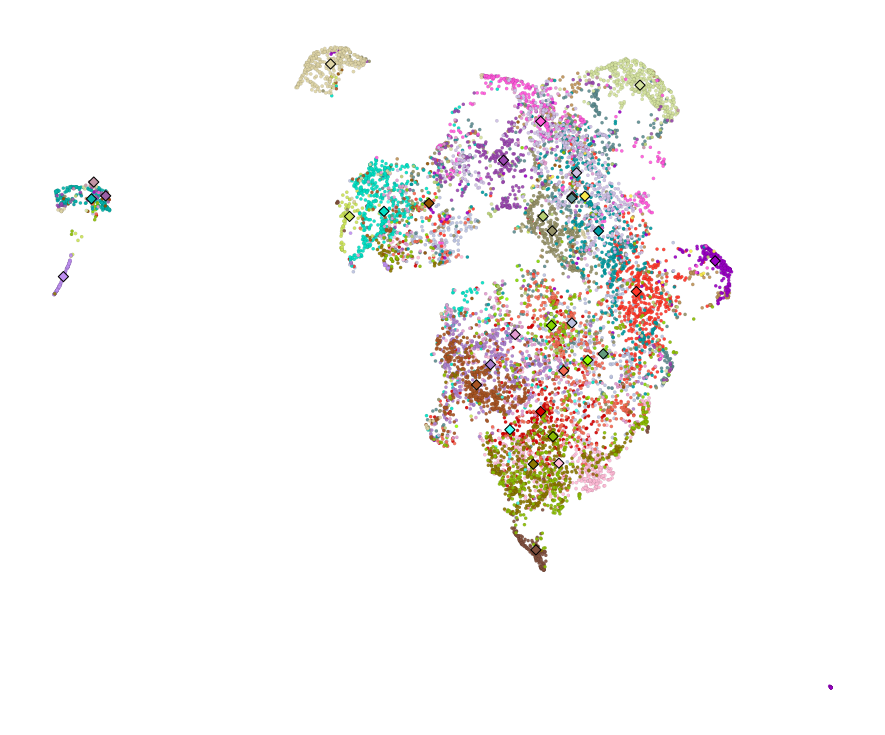

In [24]:
simple_featurespace_along_pcs(data=norm_embed, meta=meta_per_sample, 
                              vis_param='int_PID',
                                  explained_var=[],
                                  maxdims=2,
                                  scattersize=2.5,
                                  size=(6,5), colmap=cmap,
                                  centroids=True, axis_off=True, 
                                  show_nans=False, show_cbar=False, nticks=None, annotate_centroids=False,
                              out_path=today.strftime("%Y%m%d")+'_UMAP_PID.pdf'
                                  )

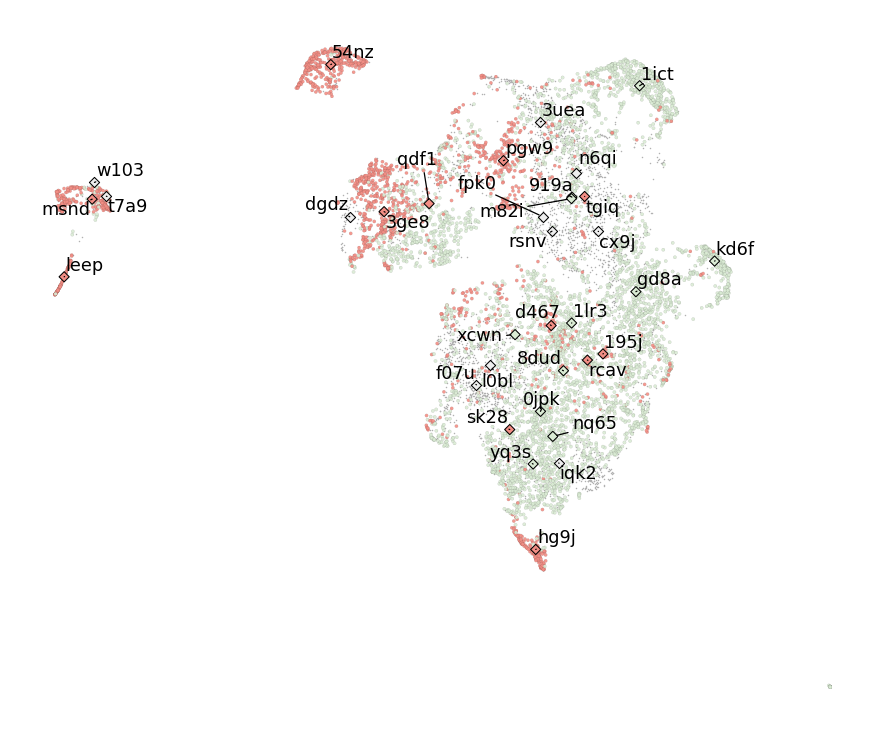

In [25]:
simple_featurespace_along_pcs(data=norm_embed, meta=meta_per_sample, 
                              vis_param='IRvsIS',
                                  explained_var=[],
                                  maxdims=2,
                                  scattersize=2.5,
                                  size=(6,5), colmap='RdYlBu_r',
                                  centroids=True, axis_off=True, annotate_centroids=True,
                                  show_nans=True, show_cbar=False, nticks=2,
                              out_path=today.strftime("%Y%m%d")+'_UMAP_IRvsIS.pdf'
                                  )